# Sentiment Analysis on IMDB Data using Long-short term memory

> <i> Sentiment classification is the task of looking at a piece of text and telling if someone likes or dislikes the thing they’re talking about. </i> 
[[1](https://towardsdatascience.com/machine-learning-word-embedding-sentiment-classification-using-keras-b83c28087456)]

## IMDB Dataset
> IMDB released a adataset containing 50K reviews with their sentiment values. This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. [[2](https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews)]

## Architecture
For this classification model, we will build a deep neural network for sentiment classification using Word embeddings. 
The model will consitst 4 differnet modules which are described in the architecture of the model is described below:<br/>
![Architecture](architeacture.png)

### Modules
> <b>Text</b><br/>
IMDB reviews dataset includes the cleaned reviews (removed symbols, lower case etc). <br/>
<br/>

> <b> Embedding Layer</b> <br/>
Word Embedding is a representation of text where words that have the same meaning have a similar representation. In other words it represents words in a coordinate system where related words, based on a corpus of relationships, are placed closer together. In the deep learning frameworks such as TensorFlow, Keras, this part is usually handled by an embedding layer which stores a lookup table to map the words represented by numeric indexes to their dense vector representations.<br/>
<br/>

> <b> Deep Network LSTM </b><br/>
Deep network takes the sequence of embedding vectors as input and converts them to a compressed representation. The compressed representation effectively captures all the information in the sequence of words in the text. The deep network part is usually an RNN or some architecture of it like LSTM/GRU. The dropout is added to overcome the tendency to overfit, which is a very common problem with RNN based networks. Please refer [here](https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21) for detailed discussion on LSTM,GRU.
<br/>

> <b> Fully Connected Layer </b><br/>
The fully connected layer takes the deep representation from the RNN/LSTM/GRU and transforms it into the final output classes or class scores. This component is comprised of fully connected layers along with batch normalization and optionally dropout layers for regularization. <br/>
<br/>

> <b> Output Layer </b><br/>
Based on the problem at hand, this layer can have either Sigmoid for binary classification or Softmax for both binary and multi classification output.<br/>

In [1]:
## input Libraries
import numpy as np
import pandas as pd
import re
import string
from tqdm import tqdm
import math
import tensorflow as tf
import sklearn

In [2]:
%tensorflow_version 2.x

In [4]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [5]:
# Read dataset from data folder
dataset = pd.read_csv('/gdrive/My Drive/data/IMDB Dataset.csv')

In [6]:
dataset.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


## Data Pre-processing

In [7]:
# Label encode sentiment 
from sklearn.preprocessing import LabelEncoder
lb = LabelEncoder()

dataset['sentiment'] = lb.fit_transform(dataset['sentiment'])

### Label Encoding
| Sentiment | Label 
| :- | -: 
| Positive | 1
| Negative | 0

In [8]:
# Function to remove all the html tags from test
def cleanhtml(raw_html):
    cleanr = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    cleantext = re.sub(cleanr, '', raw_html)
    return cleantext

In [9]:
# Function to remove all the numbers from text
def remove_numbers(text):
    text1 = re.sub(r'\d+', '', text)
    return text1

In [10]:
# Function to remove punctuations and symbols from test
def remove_symbol(text):
    for char in string.punctuation:
        text = text.replace(char,'')
    return text

In [11]:
# In this processs lets remove all symbols, html tags, numbers and lower case all the words
cleaned_corpus = []

for i in tqdm(range(len(dataset['review']))):
    temp = str(dataset['review'].iloc[i])

    # remove html tage
    temp = cleanhtml(temp)

    # remove numbers
    temp = remove_numbers(temp)

    # remove punctuations
    temp = remove_symbol(temp)
    
    # remove all the numbers 
    temp1 = []
    for i in temp.split():
        if not i.isdigit():
            temp1.append(i)

    # join the list
    temp = " ".join(temp1)
    
    # convert all the words into lower case
    temp = str(temp).lower()
    
    # remove nan
    temp = [x for x in temp.split() if str(x) != 'nan']
    
    cleaned_corpus.append(" ".join(temp))


100%|██████████| 50000/50000 [00:10<00:00, 4969.67it/s]


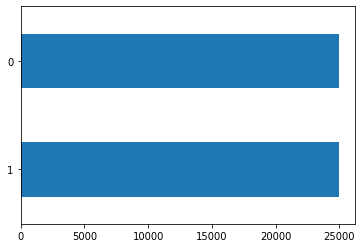

In [12]:
dataset['sentiment'].value_counts().plot(kind='barh')

### Note
> Looks like out dataset is well-balanced (Same # of review samples in both classes)

In [13]:
# Cleaning the data to remove nan(float type) from string
corpus = []
for i in cleaned_corpus:
    temp = []
    for j in i.split():
        if not j==math.nan:
            temp.append(j)
    corpus.append(" ".join(temp))
dataset['review'] = [str(i) for i in corpus]

In [14]:
# Let's split the data into training and test data
# from sklearn.model_selection import train_test_split
# X_train, X_test,y_train, y_test = train_test_split(dataset['review'], dataset['sentiment'], test_size=0.25)

In [16]:
X_train = dataset.loc[:24999, 'review'].values
X_test = dataset.loc[25000:, 'review'].values
y_train = dataset.loc[:24999, 'sentiment'].values
y_test = dataset.loc[25000:, 'sentiment'].values

### Word Embeddings
> The word embeddings of our dataset can be learned while training a neural network on the classification problem. Before it can be presented to the network, the text data is first encoded so that each word is represented by a unique integer. This data preparation step can be performed using the Tokenizer API provided with Keras. We add padding to make all the vectors of same length (max_length). Below code converts the text to integer indexes, now ready to be used in Keras embedding layer.

In [26]:
# Function to get the length of longest review
def max_length(clean_review):
    max1 = []
    for i in clean_review:
        temp = len(i.split())
        max1.append(temp)
    return max1

In [27]:
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(lower=False)
total_reviews = np.concatenate((X_train, X_test))
tokenizer.fit_on_texts(total_reviews)

# get the max length of review
max_length = max(max_length(dataset['review']))

# define vocabulary size
vocabulary_size = len(tokenizer.word_index) + 1

In [28]:
X_train_tokens = tokenizer.texts_to_sequences(X_train)
X_test_tokens = tokenizer.texts_to_sequences(X_test)

In [29]:
# Checking the length of review before and after converting to sequences
len(X_train_tokens[0]) == len(X_train[0].split())

True

In [30]:
# Padding the sequences 
X_train_pad = pad_sequences(X_train_tokens, maxlen=max_length, padding='post')
X_test_pad = pad_sequences(X_test_tokens, maxlen=max_length, padding='post')

## Build the model

In [31]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Embedding, LSTM, GRU, Dense
# # from keras.layers.embeddings import Embedding

# EMBEDDING_DIM=100
# print('Build Model..')

# model = Sequential()
# model.add(Embedding(vocabulary_size, EMBEDDING_DIM, input_length=max_length))
# model.add(GRU(units=32))
# model.add(Dense(1, activation='sigmoid'))

# # Since this is binary classification model, lets use binary_classification as loss
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [32]:
EMBEDDING_DIM=100

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocabulary_size, EMBEDDING_DIM, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [33]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 2441, 100)         21572200  
_________________________________________________________________
global_average_pooling1d_1 ( (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 24)                2424      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 25        
Total params: 21,574,649
Trainable params: 21,574,649
Non-trainable params: 0
_________________________________________________________________


## Train the model

In [34]:
print('Train..')

model.fit(X_train_pad, y_train, batch_size=128, epochs=25, validation_data=(X_test_pad, y_test), verbose=2)

Train..
Epoch 1/25
196/196 - 53s - loss: 0.6913 - accuracy: 0.5355 - val_loss: 0.6858 - val_accuracy: 0.5372
Epoch 2/25
196/196 - 53s - loss: 0.6549 - accuracy: 0.6823 - val_loss: 0.5999 - val_accuracy: 0.7490
Epoch 3/25
196/196 - 52s - loss: 0.5248 - accuracy: 0.7920 - val_loss: 0.4674 - val_accuracy: 0.8119
Epoch 4/25
196/196 - 52s - loss: 0.4032 - accuracy: 0.8523 - val_loss: 0.3809 - val_accuracy: 0.8594
Epoch 5/25
196/196 - 52s - loss: 0.3256 - accuracy: 0.8845 - val_loss: 0.3368 - val_accuracy: 0.8724
Epoch 6/25
196/196 - 52s - loss: 0.2751 - accuracy: 0.9032 - val_loss: 0.3121 - val_accuracy: 0.8783
Epoch 7/25
196/196 - 52s - loss: 0.2390 - accuracy: 0.9171 - val_loss: 0.3026 - val_accuracy: 0.8794
Epoch 8/25
196/196 - 52s - loss: 0.2099 - accuracy: 0.9272 - val_loss: 0.2868 - val_accuracy: 0.8880
Epoch 9/25
196/196 - 52s - loss: 0.1872 - accuracy: 0.9370 - val_loss: 0.3469 - val_accuracy: 0.8488
Epoch 10/25
196/196 - 52s - loss: 0.1678 - accuracy: 0.9441 - val_loss: 0.2753 - va

### Test the Model

In [45]:
test_1 = "This movie was awesome I really liked it"
test_2 = "It was really bad movie"
test = [test_1, test_2]

test_sample_token = tokenizer.texts_to_sequences(test)
test_sample_pad_seq = pad_sequences(test_sample_token, maxlen=max_length)

In [47]:
# Predict the output
model.predict(x=test_sample_pad_seq)

array([[0.92794365],
       [0.58483624]], dtype=float32)